# **MOTION PREDICTION FOR AUTONOMOUS VEHICLES**

> Authors- <br>
> Madhura Bartakke<br>
> Neha Tayade

In [1]:
!pip install --upgrade pip
!pip uninstall typing --yes
!pip uninstall torchvision --yes
!pip install torchvision==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install l5kit
print("Done!")

     |████████████████████████████████| 1.5 MB 343 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
Found existing installation: typing 3.7.4.3
Uninstalling typing-3.7.4.3:
  Successfully uninstalled typing-3.7.4.3
Found existing installation: torchvision 0.7.0
Uninstalling torchvision-0.7.0:
  Successfully uninstalled torchvision-0.7.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 5.8 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 29 kB/s  eta 0:00:011


     |████████████████████████████████| 42.9 MB 8.5 MB/s eta 0:00:011B/s eta 0:00:08     |██████████████▉                 | 20.0 MB 3.7 MB/s eta 0:00:07     |███████████████▎                | 20.5 MB 3.7 MB/s eta 0:00:07     |████████████████                | 21.4 MB 3.7 MB/s eta 0:00:06
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 62 kB 725 kB/s  eta 0:00:01
     |████████████████████████████████| 132 kB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 20.6 MB/s eta 0:00:01
  Created wheel for ptable: filename=PTable-0.9.2-py3-none-any.whl size=22907 sha256=96e6c273d09cfb49bf8e0173077d539e28aa0f41aee1f43918eecf03f369a114
  Stored in directory: /root/.cache/pip/wheels/33/df/2f/674985b3f8a2de3f96357d1eadef5110f74fa91b3785e52a54
  Created wheel for pymap3d: filename=pymap3d-2.4.3-py3-none-any.whl size=33553 sha256=96106517a3177980c58859a1fa4c70d5659

  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5035 sha256=6ede4999c6d5ee4fbccd569915003e92148a750660e8357d189d51ed200f3de0
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built ptable pymap3d transforms3d asciitree
Done!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#PyTorch libraries
import os
import torch
from torch import nn, optim
from torch import functional as F
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18, resnet50, resnet101
from typing import Dict

#L5kit libraries
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.evaluation import write_pred_csv
from l5kit.geometry import transform_points
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory

from keras.utils.conv_utils import convert_kernel
from keras.layers import (Input, Conv2D, Flatten,Dense,AveragePooling2D,Dropout,MaxPooling2D,BatchNormalization)
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

import pickle
import time

import warnings
warnings.filterwarnings("ignore")

list(os.listdir("../input/lyft-motion-prediction-autonomous-vehicles"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Configuration

In [4]:
def config():
    cfg_data = {
        'format_version': 4,
        'model_params': {
            'model_architecture': 'resnet50',#Baseline model
            'history_num_frames': 10,#Historic Frames for prediction
            'history_step_size': 1,
            'history_delta_time': 0.1,
            'future_num_frames': 50,#Future frames to predict
            'future_step_size': 1,
            'future_delta_time': 0.1,
            'lr': 1e-4,#learning rate
            'weight_path': "/kaggle/input/lyftpretrained-resnet101/lyft_resnet101_model.pth",
            'train': True,
            'predict': True
        },

        'raster_params': {
            'raster_size': [224, 224],# image size
            'pixel_size': [0.5, 0.5],# meters corresponding to a pixel
            'ego_center': [0.25, 0.5], #usually centered around the agent, can help move agent in image plane
            'map_type': 'py_semantic', #mode
            'satellite_map_key': 'aerial_map/aerial_map.png', #satellite-based map
            'semantic_map_key': 'semantic_map/semantic_map.pb', #semantic-based map
            'dataset_meta_key': 'meta.json',
            'filter_agents_threshold': 0.5 #shows agents with prob >0.5 by belonging to one of the classes(car, bike, etc)
        },
        'train_data_loader': {
            'key': 'scenes/train.zarr',
            'batch_size': 32,
            'shuffle': False,
            'num_workers': 4
        },
        'test_data_loader': {
            'key': 'scenes/test.zarr',
            'batch_size': 8,
            'shuffle': False,
            'num_workers': 2
        },
        'valid_data_loader': {
            'key': 'scenes/validate.zarr',
            'batch_size': 16,
            'shuffle': False,
            'num_workers': 4

        },

        'train_params': {
            "epochs": 10, 
            'max_num_steps':10000,#5000
            'checkpoint_every_n_steps': 5000,
            'eval_every_n_steps': 100
        
        }
    }
    return cfg_data

### Create Dataset function

In [5]:
def dataset(cfg_data, dm, base_path):
    rasterizer = build_rasterizer(cfg_data, dm)

    train_cfg = cfg_data["train_data_loader"]
    train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
    train_dataset = AgentDataset(cfg_data, train_zarr, rasterizer)
    train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], 
                                  batch_size=train_cfg["batch_size"], 
                                  num_workers=train_cfg["num_workers"])


    valid_cfg = cfg_data["valid_data_loader"]
    validate_zarr = ChunkedDataset(dm.require(valid_cfg["key"])).open()
    valid_dataset = AgentDataset(cfg_data, validate_zarr, rasterizer)
    valid_dataloader = DataLoader(valid_dataset, 
                                  shuffle=valid_cfg["shuffle"], 
                                  batch_size=valid_cfg["batch_size"], 
                                  num_workers=valid_cfg["num_workers"])

    test_cfg = cfg_data["test_data_loader"]
    test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
    test_mask = np.load(base_path + "/mask.npz")["arr_0"]
    test_dataset = AgentDataset(cfg_data, test_zarr, rasterizer, agents_mask=test_mask)
    test_dataloader = DataLoader(test_dataset, 
                                  shuffle=test_cfg["shuffle"], 
                                  batch_size=test_cfg["batch_size"], 
                                  num_workers=test_cfg["num_workers"])
    
    return train_dataloader, valid_dataloader, test_dataloader

## Models

## ResNet Model

In [6]:
class ResNet50(nn.Module):
    
    def __init__(self, cfg_data):
        super(ResNet50, self).__init__()
        
        # set pretrained=True while training
        self.backbone = resnet50(pretrained=False) 
        past_frames = cfg_data["model_params"]["history_num_frames"]
        modes = 3
        n_history_channels = (past_frames + 1) * 2
        in_channels = modes + n_history_channels ##25

        self.backbone.conv1 = nn.Conv2d(
            in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )
        
        # X, Y coords for the future positions (output shape: Bx50x2)
        future_frames = cfg_data["model_params"]["future_num_frames"]
        n_targets = 2 * future_frames
        
        # This is 512 for resnet18 ; And it is 2048 for the resnet50 and above
        model_out_features = 2048
        self.head = nn.Sequential(nn.Linear(in_features=model_out_features, out_features=4096),)

        self.out_layer = nn.Linear(4096, out_features=n_targets)
        
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        out = self.backbone.layer1(x)
        out = self.backbone.layer2(out)
        out = self.backbone.layer3(out)
        out = self.backbone.layer4(out)

        out = self.backbone.avgpool(out)
        out = torch.flatten(out, 1) 
        out = self.out_layer(self.head(out))
        
        return out

In [7]:
def train_resnet(resnet_model, train_dataloader, valid_dataloader, cfg_data, opt=None, criterion=None, lrate=1e-4):
        """Function for training the resnet model"""
        print("Building Model...")
       
        model = resnet_model
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.MSELoss(reduction="none")
        VALIDATION = True                     
                
        print("Training Resnet...")
        train_losses = []
        train_losses_mean = []
        
        val_losses = []
        val_losses_mean = []
        
        progress = range(cfg_data["train_params"]["max_num_steps"])
        
        train_iter = iter(train_dataloader)
        val_iter = iter(valid_dataloader)
        
        for i in progress:
            try:
                train_data = next(train_iter)
            except StopIteration:
                train_iter = iter(train_dataloader)
                train_data = next(train_iter)
                    
            model.train()
            torch.set_grad_enabled(True)
            
                # forward pass
            images = train_data["image"]
            #print(images.shape)
            target_probs = train_data["target_availabilities"]
            pos = train_data["target_positions"]
            #pos.shape += (pos.shape[0]*pos.shape[1])
            #print(pos.shape)
            inputs = images.to(device)
            target_probs = target_probs.unsqueeze(-1).to(device)
            target_pos = pos.to(device)
                    
            outputs = model(inputs).reshape(target_pos.shape)
            # print(outputs.shape, target_pos.shape)
            loss = criterion(outputs, target_pos)
            loss = (loss * target_probs).mean()
                    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Validation
            if VALIDATION:
                with torch.no_grad():
                    try:
                        valid_data = next(val_iter)
                    except StopIteration:
                        val_iter = iter(val_dataloader)
                        valid_data = next(val_iter)
                    model.eval()
                    images = valid_data["image"]
                    target_probs = valid_data["target_availabilities"]
                    pos = valid_data["target_positions"]
                    inputs = images.to(device)
                    target_probs = target_probs.unsqueeze(-1).to(device)
                    target_pos = pos.to(device)
                    
                    outputs = model(inputs).reshape(target_pos.shape)
                    val_loss = criterion(outputs, target_pos)
                    val_loss = (val_loss * target_probs).mean()
                    
                    val_losses.append(val_loss.item())
                    val_losses_mean.append(np.mean(val_losses))
                
                
            if i%500==0:
                print("Epoch:",str(i).zfill(2),"\tTrainLoss:",round(loss.item(), 3),"\tValLoss: ",round(val_loss.item(), 3), "\tTrainMeanLoss:",round(np.mean(train_losses),3),"\tValMeanLoss:",round(np.mean(val_losses),3))
            
            train_losses.append(loss.item())
            train_losses_mean.append(np.mean(train_losses))
            #progress.set_description(desc)
            
        return train_losses_mean, val_losses_mean, model

In [10]:
def test_resnet(model, test_dataloader, cfg_data):
    model.eval()
    torch.set_grad_enabled(False)
    # store information for evaluation
    future_coords_offsets_pd = []
    timestamps = []
    test_losses = []
    agent_ids = []
    print("Testing ResNet...")
    test_iter = iter(test_dataloader)
    
    for data in test_dataloader:
        test_data = next(test_iter)
        images = test_data["image"]
        target_probs = test_data["target_availabilities"]
        pos = test_data["target_positions"]
        inputs = images.to(device)
        target_probs = target_probs.unsqueeze(-1).to(device)
        target_pos = pos.to(device)

        outputs = model(inputs).reshape(target_pos.shape)
                    
        future_coords_offsets_pd.append(outputs.cpu().numpy().copy())
        timestamps.append(test_data["timestamp"].numpy().copy())
        agent_ids.append(test_data["track_id"].numpy().copy())
        # print(f"Test loss: ", (test_loss.numpy()))
        #save predictions as a csv file
    write_pred_csv('submission_resnet50.csv',
                   timestamps=np.concatenate(timestamps),
                   track_ids=np.concatenate(agent_ids),
                   coords=np.concatenate(future_coords_offsets_pd))
    print("ResNet done")

## LSTM Model

In [8]:
class LSTM_Encoder(nn.Module):
    def __init__(self, cfg):
        super(LSTM_Encoder, self).__init__()
        self.input_size = 2
        self.hidden_size = 128
        self.number_layers = 1
        
        self.Encoder = nn.LSTM(self.input_size, self.hidden_size, self.number_layers, batch_first = True)
        
    def forward(self,inputs):
        output,hidden_state = self.Encoder(inputs)
        return output,hidden_state
    
class LSTM_Decoder(nn.Module):
    def __init__(self, cfg):
        super(LSTM_Decoder, self).__init__()
        
        self.input_size  = 128 
        self.hidden_size = 128
        self.hidden_size_encoder = 128
        self.number_layers = 1
        self.sequence_length_decoder = 1
        self.interlayer = 256
        self.cfg = cfg
        target = 2 * self.cfg["model_params"]["future_num_frames"]
        self.Encoder = LSTM_Encoder(self.cfg)
        self.Decoder = nn.LSTM(self.input_size, self.hidden_size, self.number_layers, batch_first=True)
        self.FC_layer= nn.Sequential(nn.Linear(in_features=self.hidden_size_encoder, out_features=self.interlayer),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=self.interlayer, out_features=target))

    def forward(self,inputs):
        self.inputs = inputs.unsqueeze(dim=1)
        output,hidden_state = self.Encoder(inputs)
        inout_to_dec = torch.ones(inputs.shape[0],self.sequence_length_decoder,self.input_size).to(device)
        inout_to_dec, hidden_state = self.Decoder(inout_to_dec,(hidden_state[0],hidden_state[1]) )          
        FC_layer_output = self.FC_layer(inout_to_dec.squeeze(dim=0))
        return FC_layer_output.reshape(inputs.shape[0],self.cfg["model_params"]["future_num_frames"],-1)

### LSTM Train and Validate function

In [9]:
def train_lstm(lstm_model, train_dataloader, valid_dataloader, cfg):
    train_data = iter(train_dataloader)
    val_data = iter(valid_dataloader)

    progress_bar = range(cfg["train_params"]["max_num_steps"])
    losses_train = []
    losses_mean_train = []
    losses_val = []
    losses_mean_val = []
    print("Building Model...")
    model = lstm_model
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 5000, gamma=0.1)
    criterion = nn.MSELoss(reduction="none")
    
    validation = True
    print("Training LSTM...")
    
    for itr in progress_bar:
        try:
            train_batch = next(train_data)
        except StopIteration:
            train_data = iter(train_dataloader)
            train_batch = next(train_data)
        model.train()
        torch.set_grad_enabled(True)

        # Forward pass
        history_positions = train_batch['history_positions'].to(device)
        history_availabilities = train_batch['history_availabilities'].to(device)
        target_availabilities = train_batch["target_availabilities"].unsqueeze(-1).to(device)
        targets_position = train_batch["target_positions"].to(device)

        outputs = model(history_positions)

        loss = criterion(outputs, targets_position)
        loss = loss * target_availabilities
        loss = loss.mean()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        losses_train.append(loss.item())
        losses_mean_train.append(np.mean(losses_train))

        # Validation
        if validation :
            with torch.no_grad():
                try:
                    val_batch = next(val_data)
                except StopIteration:
                    val_data = iter(valid_dataloader)
                    val_batch = next(val_data)

                model.eval()
                # Forward pass
                target_availabilities_val = val_batch["target_availabilities"].unsqueeze(-1).to(device)
                targets_val = val_batch["target_positions"].to(device)
                history_positions_val = val_batch['history_positions'].to(device)
                history_availabilities_val = train_batch['history_availabilities'].to(device)

                outputs_val = model(history_positions_val)

                loss_v = criterion(outputs_val,targets_val)
                loss_v = loss_v * target_availabilities_val
                loss_v = loss_v.mean()

                losses_val.append(loss_v.item())

                losses_mean_val.append(np.mean(losses_val))

        if itr %500==0:
            print("Epoch:",str(itr).zfill(2),"\tTrainLoss:",round(loss.item(), 3),"\tValLoss:",round(loss_v.item(), 3),"\tTrainMeanLoss:",round(np.mean(losses_train), 3),"\tValMeanLoss:",round(np.mean(losses_val),3)) 
            
        lr_scheduler.step()
        #progress_bar.set_description(desc)
    return losses_mean_train, losses_mean_val, model

In [11]:
def test_lstm(model,test_dataloader, cfg_data):
    model.eval()
    future_coords_offsets = []
    timestamps = []
    agent_ids = []
    print("Testing LSTM...")
    with torch.no_grad():
        test_data = (test_dataloader)

        for test_batch in test_data:

            history_positions = test_batch['history_positions'].to(device)

            outputs = model(history_positions)

            future_coords_offsets.append(outputs.cpu().numpy().copy())
            timestamps.append(test_batch["timestamp"].numpy().copy())
            agent_ids.append(test_batch["track_id"].numpy().copy())
    write_pred_csv('submission_lstm.csv',
                   timestamps=np.concatenate(timestamps),
                   track_ids=np.concatenate(agent_ids),
                   coords=np.concatenate(future_coords_offsets))
    print("LSTM done")

## Main Function

In [12]:
if __name__ == '__main__':
    # List of files available in data files
    
    data_path = "../input/lyft-motion-prediction-autonomous-vehicles"
    os.environ["L5KIT_DATA_FOLDER"] = data_path
    dm = LocalDataManager(None)
    
    #configurations
    cfg_data = config()
    print("CONFIGURATION LOADED")

CONFIGURATION LOADED


In [13]:
    #Datasets
    base_path = '../input/lyft-motion-prediction-autonomous-vehicles/scenes'
    train_loader, valid_loader, test_loader = dataset(cfg_data, dm, base_path)
    print("RESNET DATASETS LOADED")
    train_loader, valid_loader, test_loader = dataset(cfg_data, dm, base_path)
    print("LSTM DATASETS LOADED")     

RESNET DATASETS LOADED
LSTM DATASETS LOADED


In [14]:
    #Calling resnet model
    resnet_model = ResNet50(cfg_data).to(device)
    #resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
    #loss_criterion = nn.MSELoss(reduction="none")
    print("RESNET MODEL LOADED")

RESNET MODEL LOADED


In [15]:
    #Calling lstm model
    lstm_model = LSTM_Decoder(cfg_data).to(device)
    print("LSTM MODEL LOADED")

LSTM MODEL LOADED


## **ResNet Model**

In [ ]:
    start = time.perf_counter()

In [16]:
    #Resnet train
    train_losses_resnet, val_losses_resnet, resnet_model = train_resnet(resnet_model, train_loader, valid_loader, cfg_data)
    filename = 'resnet50_model.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(resnet_model,f)
    
    with open(filename, 'rb') as read_file:
        resnet_model = pickle.load(read_file,  encoding='utf-8')
    print("RESNET TRAINED!")

Building Model...
Training Resnet...
Epoch: 00 	TrainLoss: 130.368 	ValLoss:  1.261 	TrainMeanLoss: nan 	ValMeanLoss: 1.261
Epoch: 500 	TrainLoss: 7.309 	ValLoss:  4.813 	TrainMeanLoss: 22.594 	ValMeanLoss: 52.47
Epoch: 1000 	TrainLoss: 6.548 	ValLoss:  16.451 	TrainMeanLoss: 15.529 	ValMeanLoss: 33.16
Epoch: 1500 	TrainLoss: 1.779 	ValLoss:  8.486 	TrainMeanLoss: 12.974 	ValMeanLoss: 25.04
Epoch: 2000 	TrainLoss: 1.073 	ValLoss:  1.577 	TrainMeanLoss: 11.545 	ValMeanLoss: 20.625
Epoch: 2500 	TrainLoss: 3.496 	ValLoss:  1.131 	TrainMeanLoss: 10.451 	ValMeanLoss: 17.722
Epoch: 3000 	TrainLoss: 1.351 	ValLoss:  20.408 	TrainMeanLoss: 9.602 	ValMeanLoss: 15.971
Epoch: 3500 	TrainLoss: 4.351 	ValLoss:  17.325 	TrainMeanLoss: 9.129 	ValMeanLoss: 15.021
Epoch: 4000 	TrainLoss: 9.722 	ValLoss:  8.116 	TrainMeanLoss: 8.772 	ValMeanLoss: 14.121
Epoch: 4500 	TrainLoss: 2.3 	ValLoss:  4.935 	TrainMeanLoss: 8.4 	ValMeanLoss: 13.05
Epoch: 5000 	TrainLoss: 3.408 	ValLoss:  1.898 	TrainMeanLoss: 8.09

In [ ]:
    end = time.perf_counter()
    print(f"Execution time for ResNet: {end - start:0.2f} seconds")

In [17]:
    test_resnet(resnet_model, test_loader, cfg_data)

Testing ResNet...
ResNet done


## Loss curves for ResNet Model

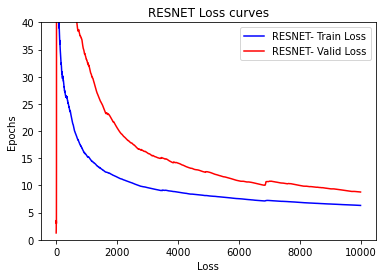

In [24]:
    fig, ax = plt.subplots()
    ax.plot(train_losses_resnet, label='RESNET- Train Loss', color='blue')
    ax.plot(val_losses_resnet, label='RESNET- Valid Loss', color = 'red')
    legend = ax.legend(loc='top right')
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.ylim((0, 40))
    plt.title('RESNET Loss curves')
    plt.show()

## **LSTM Model**

In [ ]:
    start = time.perf_counter()

In [18]:
    #LSTM train
    train_losses_lstm, val_losses_lstm, lstm_model = train_lstm(lstm_model, train_loader, valid_loader, cfg_data)
    filename = 'lstm_model.pkl'

    with open(filename, 'wb') as f:
        pickle.dump(lstm_model,f)

    with open(filename, 'rb') as read_file:
        lstm_model = pickle.load(read_file,  encoding='utf-8')
    print("LSTM TRAINED!")

Building Model...
Training LSTM...
Epoch: 00 	TrainLoss: 30.021 	ValLoss: 1.59 	TrainMeanLoss: 30.021 	ValMeanLoss: 1.59
Epoch: 500 	TrainLoss: 10.062 	ValLoss: 0.771 	TrainMeanLoss: 16.232 	ValMeanLoss: 13.275
Epoch: 1000 	TrainLoss: 0.532 	ValLoss: 36.553 	TrainMeanLoss: 10.811 	ValMeanLoss: 11.609
Epoch: 1500 	TrainLoss: 0.934 	ValLoss: 5.89 	TrainMeanLoss: 8.913 	ValMeanLoss: 9.427
Epoch: 2000 	TrainLoss: 2.081 	ValLoss: 0.147 	TrainMeanLoss: 7.966 	ValMeanLoss: 7.911
Epoch: 2500 	TrainLoss: 9.956 	ValLoss: 1.249 	TrainMeanLoss: 7.455 	ValMeanLoss: 6.903
Epoch: 3000 	TrainLoss: 7.901 	ValLoss: 18.393 	TrainMeanLoss: 7.03 	ValMeanLoss: 6.556
Epoch: 3500 	TrainLoss: 2.145 	ValLoss: 2.001 	TrainMeanLoss: 6.765 	ValMeanLoss: 6.199
Epoch: 4000 	TrainLoss: 1.169 	ValLoss: 4.592 	TrainMeanLoss: 6.554 	ValMeanLoss: 5.89
Epoch: 4500 	TrainLoss: 4.528 	ValLoss: 0.077 	TrainMeanLoss: 6.363 	ValMeanLoss: 5.672
Epoch: 5000 	TrainLoss: 10.013 	ValLoss: 0.858 	TrainMeanLoss: 6.248 	ValMeanLoss: 5

In [ ]:
    end = time.perf_counter()
    print(f"Execution time for LSTM: {end - start:0.2f} seconds")

In [19]:
    test_lstm(lstm_model, test_loader, cfg_data)
    #main()

Testing LSTM...
LSTM done


## Loss curves for LSTM Model

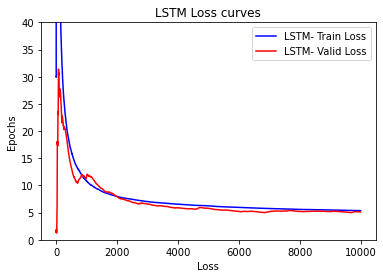

In [23]:
    fig, ax = plt.subplots()
    ax.plot(train_losses_lstm, label='LSTM- Train Loss', color='blue')
    ax.plot(val_losses_lstm, label='LSTM- Valid Loss', color = 'red')
    legend = ax.legend(loc='top right')
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.ylim((0, 40))
    plt.title('LSTM Loss curves')
    plt.show()